In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install -q gdown

import gdown

folder_url = "https://drive.google.com/drive/folders/1TiQ1_Vi7Up0k1vwV5TnjuzzRuaKatZ4_?usp=sharing"
gdown.download_folder(folder_url, output="/content/pictures", quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 1WiP043wteZ4zvwrOZheF2D0EdMJM1ntY Image 1.jpeg
Processing file 1uQhnlndAPNm88Iy0iwXiiH0o8j5NXqsV Image 2.jpeg
Processing file 118mD7_GsAO75s75_gY_IpQM9EC3iG4c- Image 3.jpeg


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1WiP043wteZ4zvwrOZheF2D0EdMJM1ntY
To: /content/pictures/Image 1.jpeg
100%|██████████| 139k/139k [00:00<00:00, 18.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uQhnlndAPNm88Iy0iwXiiH0o8j5NXqsV
To: /content/pictures/Image 2.jpeg
100%|██████████| 52.0k/52.0k [00:00<00:00, 41.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=118mD7_GsAO75s75_gY_IpQM9EC3iG4c-
To: /content/pictures/Image 3.jpeg
100%|██████████| 51.9k/51.9k [00:00<00:00, 50.5MB/s]
Download completed


['/content/pictures/Image 1.jpeg',
 '/content/pictures/Image 2.jpeg',
 '/content/pictures/Image 3.jpeg']

In [ ]:
def image_to_array(path, grayscale=True):

    img = Image.open(path)
    if grayscale:
        img = img.convert("L")  # weighted average for the colors according to the human eye

    array = np.array(img)

    return array

In [ ]:
def calculate_s(image_array):
    rows, cols = image_array.shape
    s = np.zeros_like(image_array, dtype=np.float64)

    for i in range(rows):
        for j in range(cols):
            s[i, j] = image_array[i, j] + (s[i, j-1] if j > 0 else 0)
    return s


In [ ]:
def CalculateIntegral(image_array):
    s_matrix = calculate_s(image_array)
    rows, cols = image_array.shape
    ii = np.zeros_like(image_array, dtype=np.float64)
    for i in range(rows):
        for j in range(cols):
            ii[i,j]= s_matrix[i,j] + (ii[i-1,j] if i > 0 else 0)
    return ii


In [ ]:
# row is the y and column in the x
def CalculateLocalSum(integral_image, p0, p1):
    x0, y0 = p0
    x1, y1 = p1

    image_h, image_w = integral_image.shape
    x0 = max(0, min(x0, image_w - 1))
    x1 = max(0, min(x1, image_w - 1))
    y0 = max(0, min(y0, image_h - 1))
    y1 = max(0, min(y1, image_h - 1))

    A = np.float64(integral_image[y1, x1])
    B = np.float64(integral_image[y1, x0 - 1]) if x0 > 0 else 0.0
    C = np.float64(integral_image[y0 - 1, x1]) if y0 > 0 else 0.0
    D = np.float64(integral_image[y0 - 1, x0 - 1]) if (x0 > 0 and y0 > 0) else 0.0

    return A - B - C + D





In [ ]:
def DetectEye(integral_image, kernel_width):
    n = kernel_width
    m = int(0.15 * kernel_width) # kernel height is derived from m (2.5m according to the picture)
    image_h, image_w  = integral_image.shape
    max_score = float('-inf')
    max_pos = (0,0)
    offset_top = int(0.5 *m)
    offset_bottom = int(2.0 * m)
    offset_left = int(0.5 * n)
    offset_right = int(0.5 * n)

    for y in range(offset_top, image_h - offset_bottom):
       for x in range(offset_left, image_w - offset_right):
          P1  = (int(x - 0.5 * n),  int(y - 0.5 * m))
          P2  = (int(x - 0.05 * n), int(y))
          P3  = (int(x - 0.5 * n),  int(y))
          P4  = (int(x - 0.05 * n), int(y + 0.5 * m))
          P5  = (int(x + 0.05 * n), int(y - 0.5 * m))
          P6  = (int(x + 0.5 * n),  int(y))
          P7  = (int(x + 0.05 * n), int(y))
          P8  = (int(x + 0.5 * n),  int(y + 0.5 * m))
          P9  = (int(x - 0.325 * n), int(y + 0.833 * m))
          P10 = (int(x - 0.225 * n), int(y + 2 * m))
          P11 = (int(x - 0.1 * n),   int(y + 0.833 * m))
          P12 = (int(x + 0.1 * n),   int(y + 2 * m))
          P13 = (int(x + 0.225 * n), int(y + 0.833 * m))
          P14 = (int(x + 0.325 * n), int(y + 2 * m))
          LS1 = CalculateLocalSum(integral_image, P1, P2)
          LS2 = CalculateLocalSum(integral_image, P3, P4)
          LS3 = CalculateLocalSum(integral_image, P5, P6)
          LS4 = CalculateLocalSum(integral_image, P7, P8)
          LS5 = CalculateLocalSum(integral_image, P9, P10)
          LS6 = CalculateLocalSum(integral_image, P11, P12)
          LS7 = CalculateLocalSum(integral_image, P13, P14)

          score = LS1 - LS2 + LS3 - LS4 - LS5 + LS6 - LS7
          if(score > max_score):
            max_score = score
            max_pos = (x,y)

    print("score is ", max_score)
    return max_pos

In [ ]:
def ExtractDetectedEye(image_array, max_position, kernel_width):
  n = kernel_width
  m = 0.15 * n
  output_image = np.zeros_like(image_array)
  x, y = max_position
  x_start = int(x - 0.5 * n)
  x_end   = int(x + 0.5 * n)
  y_start = int(y - 0.5 * m)
  y_end   = int(y + 2.0 * m)
  output_image[y_start:y_end, x_start:x_end] = image_array[y_start:y_end, x_start:x_end]
  return output_image

###Test cell where we call the functions

---



score is  793078.0
The max position is (567, 219)


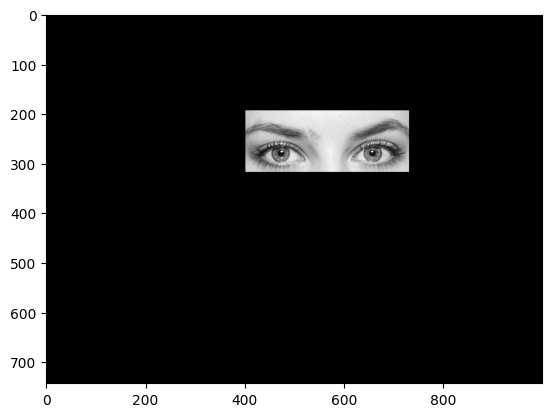

In [ ]:
Image_1 = image_to_array("/content/pictures/Image 1.jpeg") #330
arr= CalculateIntegral(Image_1)
z =DetectEye(arr,330)
print("The max position is", z)
extracted_image = ExtractDetectedEye(Image_1, z, 330)
plt.imshow(extracted_image, cmap='gray')
plt.show()

score is  555883.0
The max position is (524, 241)


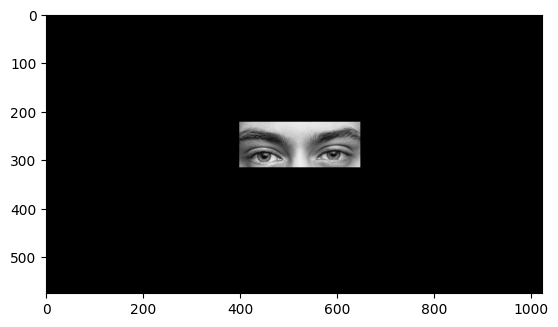

In [ ]:
Image_2 = image_to_array("/content/pictures/Image 2.jpeg")
arr= CalculateIntegral(Image_2)
z =DetectEye(arr,250)
print("The max position is", z)
extracted_image = ExtractDetectedEye(Image_2, z, 250)
plt.imshow(extracted_image, cmap='gray')
plt.show()

score is  115752.0
The max position is (201, 89)


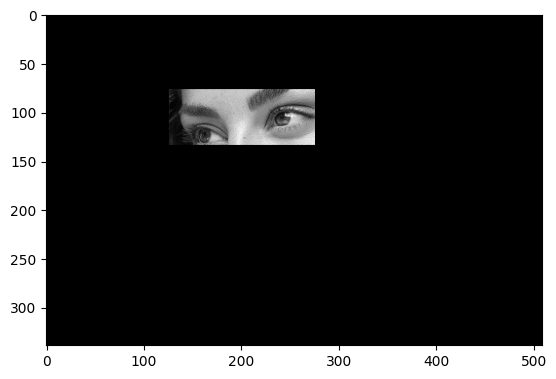

In [ ]:
Image_3 = image_to_array("/content/pictures/Image 3.jpeg")
arr= CalculateIntegral(Image_3)
z =DetectEye(arr,150)
print("The max position is", z)
extracted_image = ExtractDetectedEye(Image_3, z, 150)
plt.imshow(extracted_image, cmap='gray')
plt.show()